In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from sklearn import preprocessing

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# Read the cleaned file
df = pd.read_csv('preprocessing/SA_clean.csv')
df.shape

c:\program files\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (27,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(61870, 43)

In [4]:
df.columns

Index(['Purch.Doc.', 'Item', 'Changed On', 'Short Text', 'Material', 'CoCd',
       'Plnt', 'SLoc', 'Matl Group', 'PO Quantity', 'OUn', 'OPU', 'Eq. To',
       'Net Price', 'Per', 'Net Value', 'Gross value', 'Overdel. Tol.',
       'Underdel.Tol.', 'Item.1', 'BUn', 'Non-deductible', 'Price Date',
       'Effective value', 'PTm', 'Net Weight', 'Un', 'Profit Ctr',
       'Gross Weight', 'Volume', 'RShLi', 'MTyp', 'NCM Code', 'Reb.basis',
       'Priority (Material Required Within)', 'Ordered By', 'Approved By',
       'Priority', 'Section', 'Indenter ID', 'Input Tax Credit', 'Order_yr',
       'Order_mnth'],
      dtype='object')

In [5]:
df['Order_yr'].value_counts(normalize=True)

2019   0.93
2018   0.07
Name: Order_yr, dtype: float64

# Remove Material Group not required for clustering - ASSETS and SERVICES
Focussing on feed related items

In [6]:
# The objctive is to find some pattern in the items bought, so remove assets and services and Fuel2 Fuel 1, GNRL0
#matlGrp = ['ASSETS','SERVICE','GNRL0','FUEL1','FUEL2']
matlGrp = ['ASSETS','SERVICE']
matlGrp

['ASSETS', 'SERVICE']

In [7]:
df[df['Matl Group'].isin(matlGrp)].shape

(1851, 43)

In [8]:
df[df['Matl Group'].isin(matlGrp)]['Gross value'].sum()

243092547.11

In [9]:
df[df['Matl Group'].isin(matlGrp)]['Order_yr'].value_counts(normalize=True)

2019   0.83
2018   0.17
Name: Order_yr, dtype: float64

In [10]:
df.shape

(61870, 43)

In [11]:
df_cluster = df[~df['Matl Group'].isin(matlGrp)]
df_cluster.shape

(60019, 43)

In [12]:
# Get all Mat code with Bolero and remove them too 

In [13]:
df_cluster[df_cluster['Short Text'].str.contains('Bolero')].shape

(46, 43)

In [14]:
df_cluster[df_cluster['Short Text'].str.contains('Bolero')].head(10)

,Purch.Doc.,Item,Changed On,Short Text,Material,CoCd,Plnt,SLoc,Matl Group,PO Quantity,...,Reb.basis,Priority (Material Required Within),Ordered By,Approved By,Priority,Section,Indenter ID,Input Tax Credit,Order_yr,Order_mnth
11813,7500085034,10,2019-01-08,0084777 Kamani Bush M-Bolero,7706350.00,7860,1950,BK03,9911,4.00,...,520.00,1,54639,54651,High,Bakal,54651,T4,2019,1
12085,7500085273,10,2019-01-15,028346CED Frt.Center Bonnet Assy Bolero,7708300.00,7860,1950,BK03,9903,1.00,...,5485.96,1,54639,54651,High,Bakal,54651,T4,2019,1
12086,7500085273,20,2019-01-15,0119AAN01210A Frt Bumper Assy MTL Bolero,7708300.00,7860,1950,BK03,9903,1.00,...,3286.35,0,0,0,Normal,0,0,T4,2019,1
12087,7500085273,30,2019-01-15,0028334 Frt.Bonnet Hings Kabja RH Bolero,7708300.00,7860,1950,BK03,9903,1.00,...,2304.80,0,0,0,Normal,0,0,T4,2019,1
12088,7500085273,40,2019-01-15,0028330 Frt.Bonnet Hings Kabja LH Bolero,7708300.00,7860,1950,BK03,9903,1.00,...,481.73,0,0,0,Normal,0,0,T4,2019,1
12089,7500085273,50,2019-01-15,0102CN0560A Fender Assy MTL RH M-Bolero,7708300.00,7860,1950,BK03,9903,1.00,...,481.73,0,0,0,Normal,0,0,T4,2019,1
12530,7500085644,10,2019-01-29,0116CN0020N Wiper Water Tank M-Bolero,7708350.00,7860,1950,BK03,9903,2.00,...,1632.96,1,54639,54651,High,Bakal,54651,T4,2019,1
26947,7500085806,30,2019-02-04,Balence Rod (U Clamp) Patti M-Bolero,7708310.00,7860,1950,BK03,9911,10.00,...,324.00,0,0,0,Normal,0,0,T4,2019,2
27120,7500085929,40,2019-02-08,F002G20886-4AR Brush Gear Assy M-Bolero,7706920.00,7860,1950,BK03,9905,2.00,...,855.48,1,54639,54651,High,Bakal,54651,T4,2019,2
27137,7500085937,20,2019-02-08,Front Hub Oil Seal Mahindra Bolero,7705990.00,7860,1950,BK03,9900,80.00,...,1440.00,1,54639,54651,High,Bakal,54651,T4,2019,2


In [15]:
df_cluster[df_cluster['Short Text'].str.contains('Bolero')]['Matl Group'].value_counts()

9903    25
9905     5
9900     5
9911     3
9913     3
9906     2
9907     2
9902     1
Name: Matl Group, dtype: int64

In [16]:
# 99 series is hardware maintenance  related items...get all of the 99 series group

In [17]:
df_cluster[df_cluster['Matl Group'].str[:2] == '99']['Matl Group'].value_counts()

9906    317
9905    204
9914    127
9903    102
9908     86
9900     86
9911     85
9913     81
9907     73
9904     67
9902     65
9910     41
9912     41
9909     26
9901     15
9915      5
Name: Matl Group, dtype: int64

In [18]:
df_cluster[df_cluster['Matl Group'].str[:2] == '99'].shape

(1421, 43)

In [19]:
df_cluster[df_cluster['Matl Group'].str[:2] == '99']['Gross value'].sum()

7141000.91

In [20]:
MatlGrp_99 = df_cluster[df_cluster['Matl Group'].str[:2] == '99']['Matl Group'].unique()
MatlGrp_99

array(['9913', '9915', '9908', '9911', '9900', '9914', '9903', '9906',
       '9902', '9907', '9904', '9912', '9905', '9910', '9901', '9909'],
      dtype=object)

In [21]:
df_cluster.shape

(60019, 43)

In [22]:
## NOT RUN
# df_cluster = df_cluster[~df_cluster['Matl Group'].isin(MatlGrp_99)]
# df_cluster.shape

In [23]:
## Not run..this is food items group 
# df[df['Matl Group'].str.startswith('04',na=False)].head(10)

In [24]:
df_cluster.columns

Index(['Purch.Doc.', 'Item', 'Changed On', 'Short Text', 'Material', 'CoCd',
       'Plnt', 'SLoc', 'Matl Group', 'PO Quantity', 'OUn', 'OPU', 'Eq. To',
       'Net Price', 'Per', 'Net Value', 'Gross value', 'Overdel. Tol.',
       'Underdel.Tol.', 'Item.1', 'BUn', 'Non-deductible', 'Price Date',
       'Effective value', 'PTm', 'Net Weight', 'Un', 'Profit Ctr',
       'Gross Weight', 'Volume', 'RShLi', 'MTyp', 'NCM Code', 'Reb.basis',
       'Priority (Material Required Within)', 'Ordered By', 'Approved By',
       'Priority', 'Section', 'Indenter ID', 'Input Tax Credit', 'Order_yr',
       'Order_mnth'],
      dtype='object')

In [25]:
# For clustering we will use only the 'Net Price','Gross value' and calculate the frequency 

In [26]:
df_cluster['Purch.Doc.'].nunique()

41678

In [27]:
df_cluster[['Gross value','Net Price']].describe()

,Gross value,Net Price
count,60019.00,60019.00
mean,395148.32,7731.01
std,2334794.93,61093.89
min,0.90,0.01
25%,11451.59,23.94
50%,104874.00,30.95
75%,295900.00,312.50
max,212000000.00,3221288.00


In [28]:
df_cluster['Order_yr'].value_counts(normalize=True)

2019   0.94
2018   0.06
Name: Order_yr, dtype: float64

In [29]:
# Can explore removing non essntial items 
# Matl Group - 2700,01,03 - IT related items...

In [30]:
df_cluster.shape

(60019, 43)

# Summarise data 
Summarise data on 'Short Text' ( Material Name/description) 

In [31]:
df_cluster['Short Text'].nunique()

6248

In [32]:
df_sum = df_cluster.groupby('Short Text',as_index=False).agg(
    # Get count/frequency, can be any column
    NumTimesBought=('Purch.Doc.','count'),
    # Get total Gross Val 
    SumGrossValue=('Gross value','sum'),
    # Per unit price
    AvgPerUnitCost = ('Net Price','mean')
    
    )

df_sum.shape

(6248, 4)

In [33]:
df_sum.head()

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost
0,"""1/4 Ratchet 7-13mm Nuts",1,10250.00,1271.00
1,"""IND. Air Heating Ele. 2000 w ,240 V""",1,9880.00,2470.00
2,'biquiti - AirGrid M5 Hi-Power 27dbi,1,14400.00,7200.00
3,0028330 Frt.Bonnet Hings Kabja LH Bolero,1,719.00,481.73
4,0028334 Frt.Bonnet Hings Kabja RH Bolero,1,3440.00,2304.80


In [34]:
df_sum.sort_values(by=['SumGrossValue'],ascending =False).head(10)

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost
3110,IB Ross Broiler Finisher Feed,7864,2484004973.38,29.04
3112,IB Ross Broiler Starter Feed,6965,1832625208.50,30.29
5402,Soya Bean - (MP),2770,1296246620.39,36982.17
880,B4 IB Ross Feed,34,1054080000.00,27.03
5400,Soya Bean - (A),2130,1041177465.28,37573.95
3673,Maize,2328,929928411.41,17.80
3111,IB Ross Broiler Pre-Starter Feed,5280,881006742.00,31.71
4253,PL-3,50,836547216.05,24.87
876,B1 IB Ross Feed,57,820581512.40,29.14
4254,PL-4,43,817984426.00,25.14


In [35]:
df_sum.sort_values(by=['NumTimesBought'],ascending =False).head(10)

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost
3110,IB Ross Broiler Finisher Feed,7864,2484004973.38,29.04
3112,IB Ross Broiler Starter Feed,6965,1832625208.50,30.29
3111,IB Ross Broiler Pre-Starter Feed,5280,881006742.00,31.71
4997,Rice Bran Boiled,3838,247969115.24,21.07
5402,Soya Bean - (MP),2770,1296246620.39,36982.17
4999,Rice Bran Raw,2674,147438214.48,19.01
5399,Soya Bean,2672,542905344.06,35946.06
3673,Maize,2328,929928411.41,17.80
5400,Soya Bean - (A),2130,1041177465.28,37573.95
5002,Rice Husk (New),1417,57325319.65,3252.99


In [36]:
df_sum.sort_values(by=['SumGrossValue'],ascending =True).head(10)

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost
6222,activate wd (3*30),1,0.90,0.01
1361,CKS Sreews 8*32,1,1.44,0.48
6092,Washer M5 TK-02687,1,2.00,0.02
5232,Screw 8 No.,1,4.00,0.20
4278,PP Bag Broiler Pre Starter (50Kg),2,4.50,0.01
5109,"SELF CENTRED BONDED SEAL 1/4""",1,5.00,5.00
6184,Wiring Clip 10.No (General),1,7.07,1.01
4261,PLUMBER THRADE,1,8.00,8.00
1320,Bushing- For Plateau- TK- 07814B,1,8.00,0.08
2728,"Gi Nipple 1/2""X3""",1,10.00,5.00


In [37]:
df_sum.sort_values(by=['NumTimesBought'],ascending =True).head(10)

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost
0,"""1/4 Ratchet 7-13mm Nuts",1,10250.00,1271.00
3726,Mcb Box 16 Way,1,38885.00,1201.90
3723,Maxtreat 9735,1,9450.00,90.00
3718,Maxtreat 3226,1,2380.00,68.00
3712,Maxquat 50,1,8470.00,242.00
3711,Maxclean 05 (7860),1,20500.00,205.00
3710,Max Card M 3Mtr Connectore,1,200.00,200.00
3727,Mcb Box 2 Way,1,450.00,30.00
3706,Material for insulation 100 Density,1,222720.00,58.00
3701,Mastiwok,1,5664.00,141.60


In [38]:
df_sum[['NumTimesBought','SumGrossValue']].describe()

,NumTimesBought,SumGrossValue
count,6248.00,6248.00
mean,9.61,3795839.76
std,174.14,58540787.19
min,1.00,0.90
25%,1.00,1391.50
50%,1.00,5690.00
75%,2.00,32910.00
max,7864.00,2484004973.38


In [39]:
# How many with 1 time purchase
df_sum[df_sum['NumTimesBought']==1].shape[0] / df_sum.shape[0],df_sum[df_sum['NumTimesBought'] == 1].shape[0]

(0.6272407170294494, 3919)

In [40]:
df_sum[df_sum['NumTimesBought'] <= 2].shape[0] / df_sum.shape[0],df_sum[df_sum['NumTimesBought'] <= 2].shape[0]

(0.8029769526248399, 5017)

In [41]:
df_sum[df_sum['NumTimesBought'] <= 3].shape[0] / df_sum.shape[0],df_sum[df_sum['NumTimesBought'] <= 3].shape[0]

(0.8706786171574904, 5440)

In [42]:
df_sum[df_sum['NumTimesBought'] <= 4].shape[0] / df_sum.shape[0],df_sum[df_sum['NumTimesBought'] <= 4].shape[0]

(0.9026888604353394, 5640)

In [43]:
df_sum[df_sum['NumTimesBought'] <= 5].shape[0] / df_sum.shape[0],df_sum[df_sum['NumTimesBought'] <= 5].shape[0]

(0.9223751600512163, 5763)

In [44]:
df_sum[df_sum['NumTimesBought'] <= 6].shape[0] / df_sum.shape[0],df_sum[df_sum['NumTimesBought'] <= 6].shape[0]

(0.9356594110115237, 5846)

In [45]:
df_sum[df_sum['NumTimesBought'] <= 10].shape[0] / df_sum.shape[0],df_sum[df_sum['NumTimesBought'] <= 10].shape[0]

(0.9615877080665813, 6008)

# Process for cluster 

In [46]:
# Scale data

df_t = df_sum.drop(['Short Text'], axis='columns')
scaler = preprocessing.StandardScaler()
df_scaled = scaler.fit_transform(df_t) # its an array 
df_scaled = pd.DataFrame(df_scaled, columns = df_t.columns) # convert back to data frame
df_scaled.head()

,NumTimesBought,SumGrossValue,AvgPerUnitCost
0,-0.05,-0.06,-0.10
1,-0.05,-0.06,-0.08
2,-0.05,-0.06,-0.01
3,-0.05,-0.06,-0.11
4,-0.05,-0.06,-0.08


# Clustering

In [47]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster)
    kmeans.fit(df_scaled)
    SSE.append(kmeans.inertia_)

In [48]:
df_t = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})

Text(0, 0.5, 'Inertia')

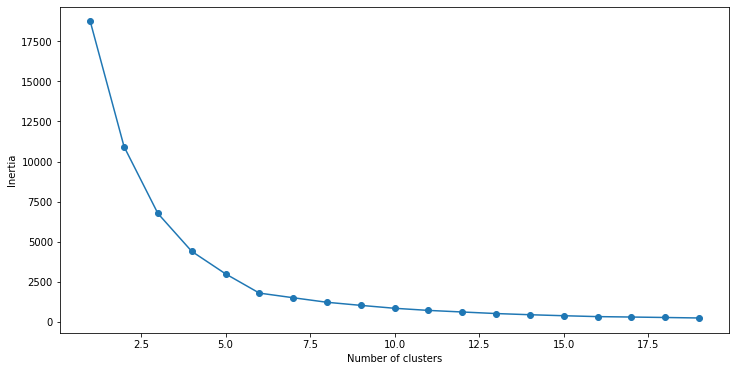

In [49]:
plt.figure(figsize=(12,6))
plt.plot(df_t['Cluster'], df_t['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [50]:
# Get 4 clusters 

In [51]:
df_scaled.head()

,NumTimesBought,SumGrossValue,AvgPerUnitCost
0,-0.05,-0.06,-0.10
1,-0.05,-0.06,-0.08
2,-0.05,-0.06,-0.01
3,-0.05,-0.06,-0.11
4,-0.05,-0.06,-0.08


In [52]:
km1 = KMeans(n_clusters = 4)
km1.fit(df_scaled)

KMeans(n_clusters=4)

In [53]:
km1.inertia_

4403.290301803926

In [54]:
km1_5 = KMeans(n_clusters = 5)
km1_5.fit(df_scaled)
km1_5.inertia_

2991.431226356612

In [55]:
km1_6 = KMeans(n_clusters = 6)
km1_6.fit(df_scaled)
km1_6.inertia_

1788.6766495115596

# Option 2 - remove per unit cost 

In [56]:
# Scale data

# df_t = df_sum.drop(['Short Text','AvgPerUnitCost'], axis='columns')
# scaler = preprocessing.StandardScaler()
# df_scaled = scaler.fit_transform(df_t) # its an array 
# df_scaled = pd.DataFrame(df_scaled, columns = df_t.columns) # convert back to data frame
# df_scaled.head()

df_scaled.drop(['AvgPerUnitCost'], axis='columns',inplace=True)
df_scaled.head()

,NumTimesBought,SumGrossValue
0,-0.05,-0.06
1,-0.05,-0.06
2,-0.05,-0.06
3,-0.05,-0.06
4,-0.05,-0.06


# Clustering

In [57]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster)
    kmeans.fit(df_scaled)
    SSE.append(kmeans.inertia_)

In [58]:
df_t = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})

Text(0, 0.5, 'Inertia')

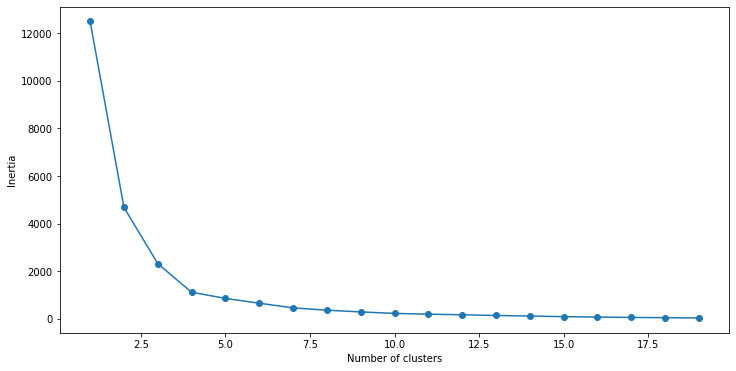

In [59]:
plt.figure(figsize=(12,6))
plt.plot(df_t['Cluster'], df_t['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Cluster 2 

In [60]:
df_scaled.head()

,NumTimesBought,SumGrossValue
0,-0.05,-0.06
1,-0.05,-0.06
2,-0.05,-0.06
3,-0.05,-0.06
4,-0.05,-0.06


In [61]:
km2 = KMeans(n_clusters = 4)
km2.fit(df_scaled)

KMeans(n_clusters=4)

In [62]:
km2.inertia_

1114.7191941550313

In [63]:
km1.inertia_

4403.290301803926

In [64]:
km1_5.inertia_

2991.431226356612

# Will use the cluster with lesser inertia - km2

In [65]:
# Add the clusters Labels to the data frame
df_sum['Cluster_km'] = km2.labels_

In [66]:
df_sum['Cluster_km'].value_counts()

0    6222
2      17
3       7
1       2
Name: Cluster_km, dtype: int64

# Get summary - Average

In [67]:
df_sum.head()

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster_km
0,"""1/4 Ratchet 7-13mm Nuts",1,10250.00,1271.00,0
1,"""IND. Air Heating Ele. 2000 w ,240 V""",1,9880.00,2470.00,0
2,'biquiti - AirGrid M5 Hi-Power 27dbi,1,14400.00,7200.00,0
3,0028330 Frt.Bonnet Hings Kabja LH Bolero,1,719.00,481.73,0
4,0028334 Frt.Bonnet Hings Kabja RH Bolero,1,3440.00,2304.80,0


In [68]:
df_km_sum = df_sum.groupby('Cluster_km',as_index=False).agg(
    NumMatInCluster=('NumTimesBought','count'),
    Avg_NumTimesBought=('NumTimesBought','mean'),
    Sum_NumTimesBought=('NumTimesBought','sum'),
    Avg_SumGrossValue=('SumGrossValue','mean'),
    Sum_SumGrossValue=('SumGrossValue','sum'),
    Avg_AvgPerUnitCost = ('AvgPerUnitCost','mean'),
)

df_km_sum

,Cluster_km,NumMatInCluster,Avg_NumTimesBought,Sum_NumTimesBought,Avg_SumGrossValue,Sum_SumGrossValue,Avg_AvgPerUnitCost
0,0,6222,3.47,21578,666028.51,4144029368.09,7716.94
1,1,2,7414.50,14829,2158315090.94,4316630181.88,29.67
2,2,17,112.94,1920,598180903.52,10169075359.91,4166.76
3,3,7,3098.86,21692,726667416.12,5086671912.86,15798.82


# Explore  more (  km2 ) 

In [69]:
df_sum[df_sum['Cluster_km'] == 0].head()

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster_km
0,"""1/4 Ratchet 7-13mm Nuts",1,10250.00,1271.00,0
1,"""IND. Air Heating Ele. 2000 w ,240 V""",1,9880.00,2470.00,0
2,'biquiti - AirGrid M5 Hi-Power 27dbi,1,14400.00,7200.00,0
3,0028330 Frt.Bonnet Hings Kabja LH Bolero,1,719.00,481.73,0
4,0028334 Frt.Bonnet Hings Kabja RH Bolero,1,3440.00,2304.80,0


In [70]:
df_sum[df_sum['Cluster_km'] == 1]

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster_km
3110,IB Ross Broiler Finisher Feed,7864,2484004973.38,29.04,1
3112,IB Ross Broiler Starter Feed,6965,1832625208.50,30.29,1


In [71]:
df_sum[df_sum['Cluster_km'] == 2].head()

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster_km
876,B1 IB Ross Feed,57,820581512.40,29.14,2
877,B2 IB Ross Feed,44,631991204.70,27.61,2
878,B3 IB Ross Feed,39,636587726.50,26.24,2
880,B4 IB Ross Feed,34,1054080000.00,27.03,2
1337,C2,18,369002000.00,24.19,2


In [72]:
df_sum[df_sum['Cluster_km'] == 3]

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster_km
3111,IB Ross Broiler Pre-Starter Feed,5280,881006742.00,31.71,3
3673,Maize,2328,929928411.41,17.80,3
4997,Rice Bran Boiled,3838,247969115.24,21.07,3
4999,Rice Bran Raw,2674,147438214.48,19.01,3
5399,Soya Bean,2672,542905344.06,35946.06,3
5400,Soya Bean - (A),2130,1041177465.28,37573.95,3
5402,Soya Bean - (MP),2770,1296246620.39,36982.17,3


# Visualization

In [73]:
df_sum.columns

Index(['Short Text', 'NumTimesBought', 'SumGrossValue', 'AvgPerUnitCost',
       'Cluster_km'],
      dtype='object')

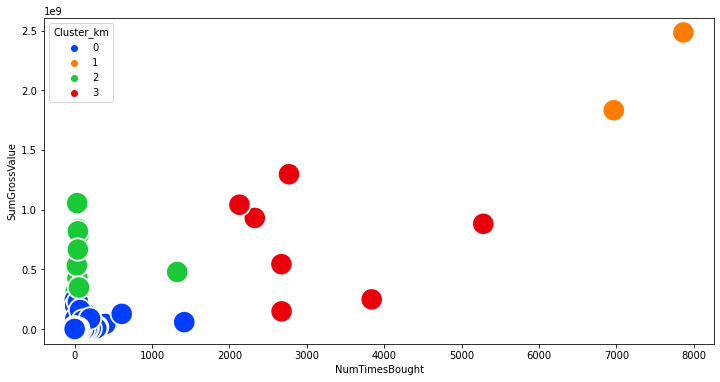

In [74]:
plt.figure(figsize = (12, 6))
sns.scatterplot(data=df_sum, x="NumTimesBought", y="SumGrossValue", hue="Cluster_km",palette="bright",s=500);

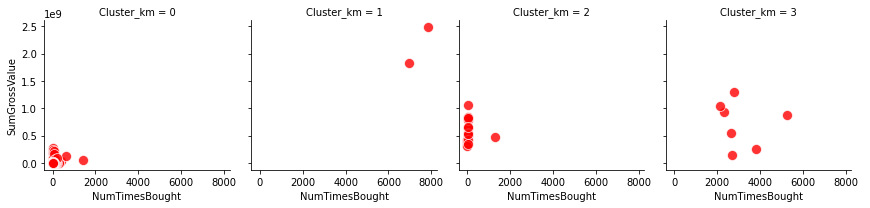

In [75]:
g = sns.FacetGrid(df_sum, col='Cluster_km')
g.map(sns.scatterplot, "NumTimesBought", "SumGrossValue", s=100, alpha=.8,color='red',x_jitter=.1)
g.add_legend();

In [76]:
%whos DataFrame

Variable     Type         Data/Info
-----------------------------------
df           DataFrame           Purch.Doc.  Item  <...>[61870 rows x 43 columns]
df_cluster   DataFrame           Purch.Doc.  Item  <...>[60019 rows x 43 columns]
df_km_sum    DataFrame       Cluster_km  NumMatInCl<...>.86            15798.82  
df_scaled    DataFrame          NumTimesBought  Sum<...>\n[6248 rows x 2 columns]
df_sum       DataFrame                             <...>\n[6248 rows x 5 columns]
df_t         DataFrame        Cluster      SSE\n0  <...>.85\n18       19    32.64


In [77]:
df_sum.columns

Index(['Short Text', 'NumTimesBought', 'SumGrossValue', 'AvgPerUnitCost',
       'Cluster_km'],
      dtype='object')

# Add the cluster value in  the raw/cleaned file and write the files

In [78]:
df.shape

(61870, 43)

In [79]:
df_info = df.merge(df_sum, on='Short Text', how='left')
df_info.shape

(61870, 47)

In [80]:
# Write the files 
df_info.to_csv("preprocessing/SA_clean_withClusterResults.csv", index=False)

# Algo clustering

In [81]:
df_sum.head()

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster_km
0,"""1/4 Ratchet 7-13mm Nuts",1,10250.00,1271.00,0
1,"""IND. Air Heating Ele. 2000 w ,240 V""",1,9880.00,2470.00,0
2,'biquiti - AirGrid M5 Hi-Power 27dbi,1,14400.00,7200.00,0
3,0028330 Frt.Bonnet Hings Kabja LH Bolero,1,719.00,481.73,0
4,0028334 Frt.Bonnet Hings Kabja RH Bolero,1,3440.00,2304.80,0


In [82]:
df_t = df_sum.drop(['Short Text','AvgPerUnitCost','Cluster_km'], axis='columns')
scaler = preprocessing.StandardScaler()
df_scaled = scaler.fit_transform(df_t) # its an array 
df_scaled = pd.DataFrame(df_scaled, columns = df_t.columns) # convert back to data frame
df_scaled.head()

,NumTimesBought,SumGrossValue
0,-0.05,-0.06
1,-0.05,-0.06
2,-0.05,-0.06
3,-0.05,-0.06
4,-0.05,-0.06


In [83]:
agglomirative = AgglomerativeClustering()

In [84]:
clusters = agglomirative.fit(df_scaled)

In [85]:
def plot_dendrogram(model):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix)

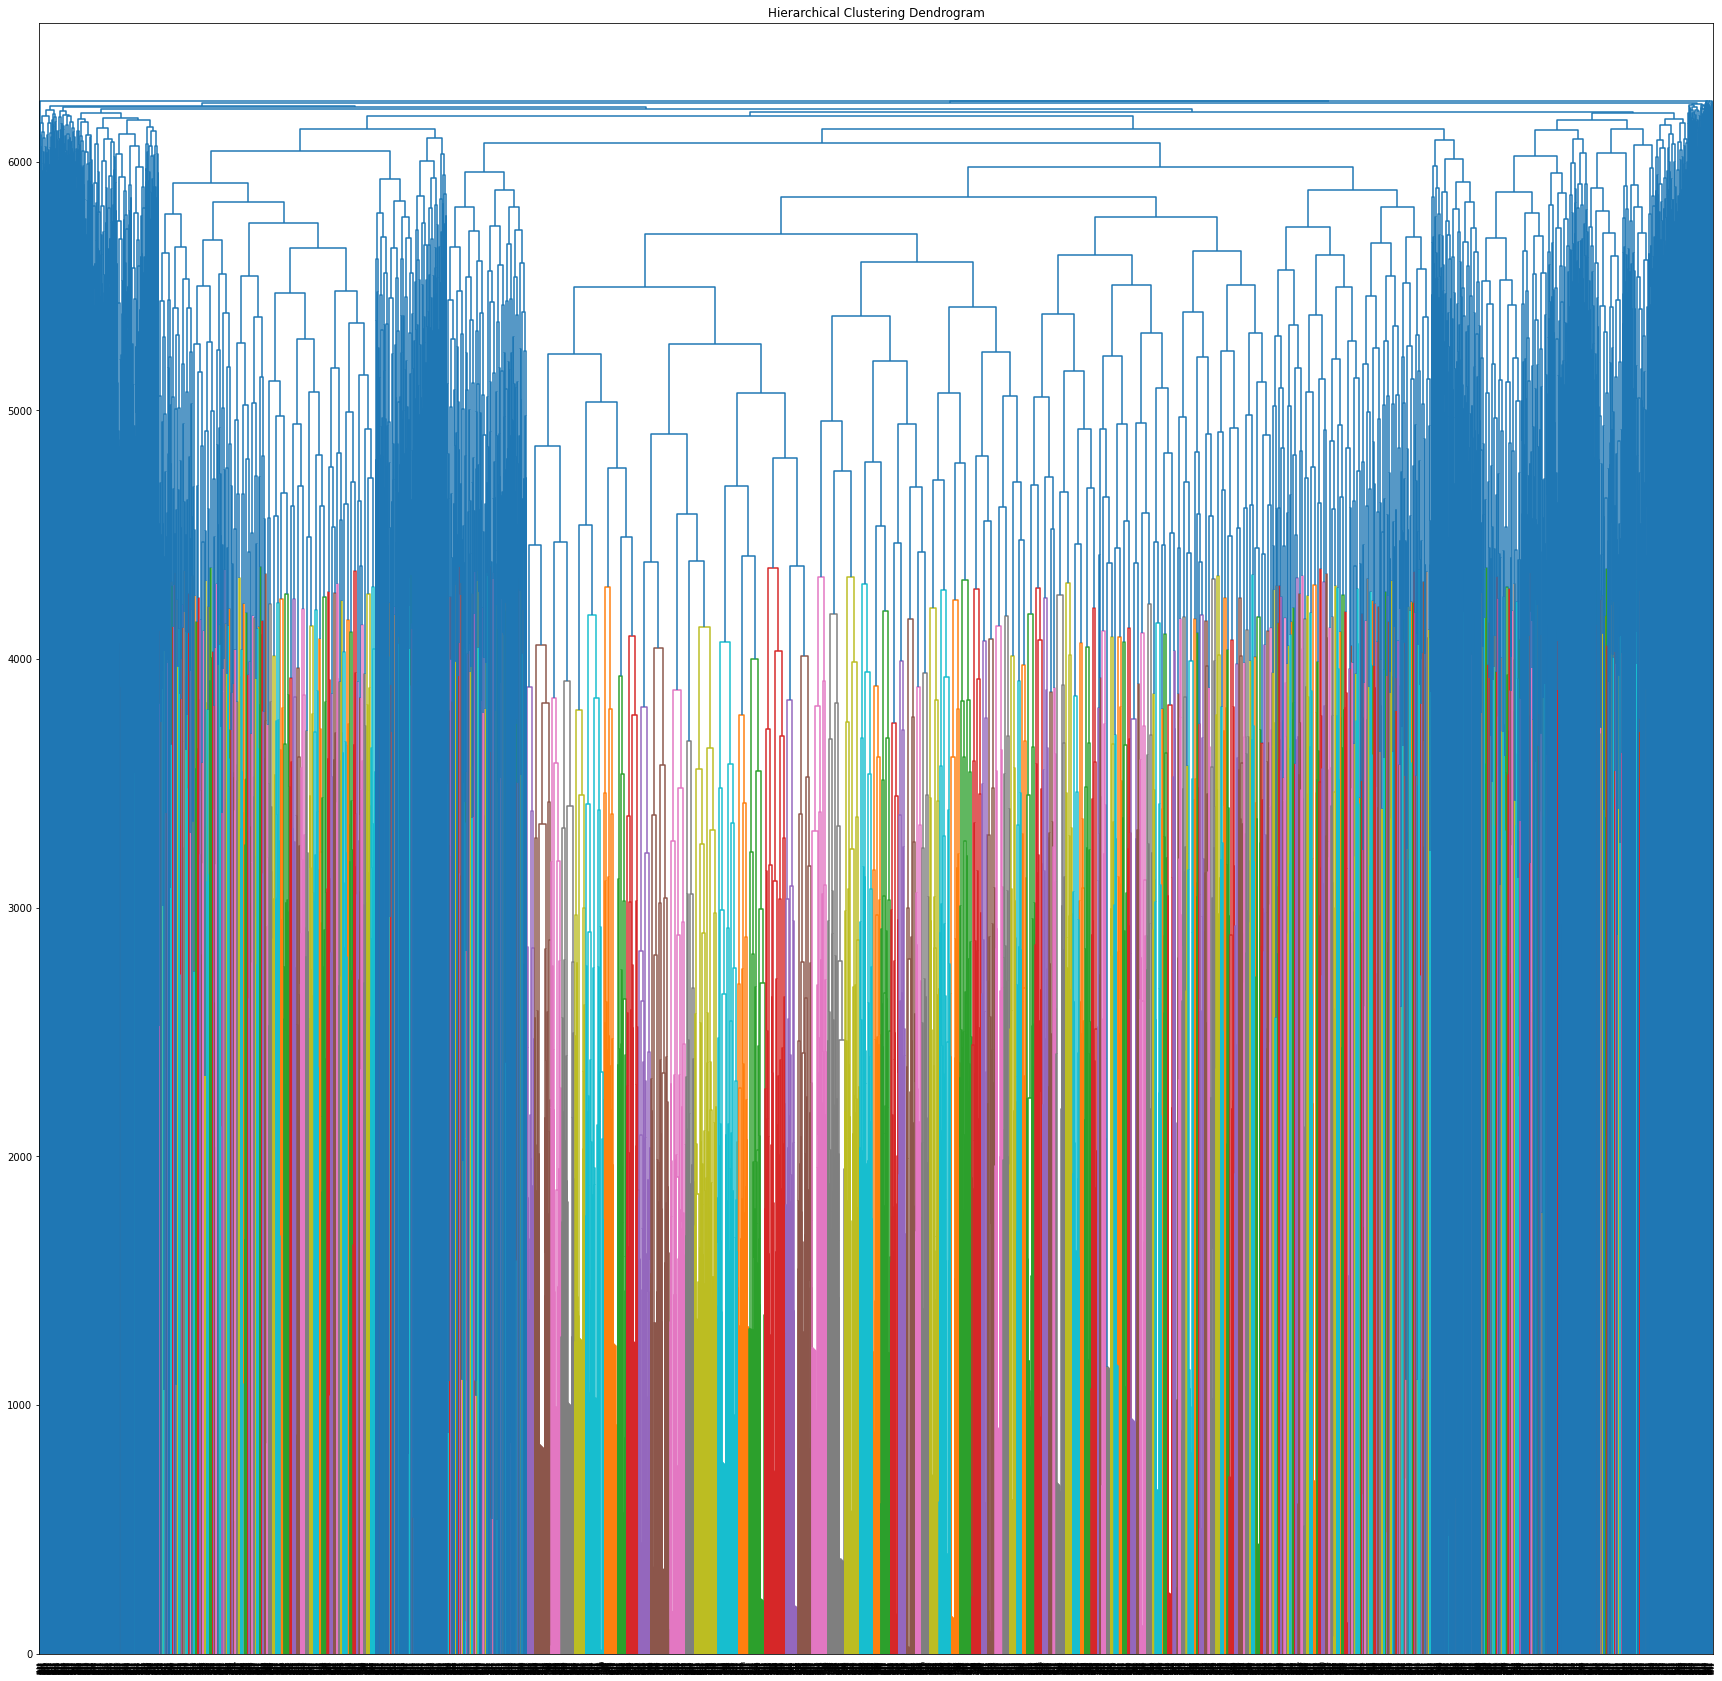

In [86]:
plt.figure(figsize=(30,30))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clusters)

In [87]:
# Difficult to make out how many clusters to me made from this, lets go with 4 

In [88]:
agglomirative4 = AgglomerativeClustering(n_clusters=4)
agglomirative_clusters = agglomirative4.fit(df_scaled)

In [89]:
agglomirative_clusters.labels_

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [90]:
agglomirative_clusters.get_params

<bound method BaseEstimator.get_params of AgglomerativeClustering(n_clusters=4)>

In [91]:
# Add the clusters to the data frame
df_sum['Cluster_agg'] = agglomirative_clusters.labels_

In [92]:
df_sum.head()

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster_km,Cluster_agg
0,"""1/4 Ratchet 7-13mm Nuts",1,10250.00,1271.00,0,2
1,"""IND. Air Heating Ele. 2000 w ,240 V""",1,9880.00,2470.00,0,2
2,'biquiti - AirGrid M5 Hi-Power 27dbi,1,14400.00,7200.00,0,2
3,0028330 Frt.Bonnet Hings Kabja LH Bolero,1,719.00,481.73,0,2
4,0028334 Frt.Bonnet Hings Kabja RH Bolero,1,3440.00,2304.80,0,2


In [93]:
df_sum['Cluster_agg'].value_counts()

2    6216
0      23
1       7
3       2
Name: Cluster_agg, dtype: int64

In [94]:
# Summarise by the agglomirative_clusters
df_algo_sum = df_sum.groupby('Cluster_agg',as_index=False).agg(
    NumMatInCluster=('NumTimesBought','count'),
    Avg_NumTimesBought=('NumTimesBought','mean'),
    Sum_NumTimesBought=('NumTimesBought','sum'),
    Avg_SumGrossValue=('SumGrossValue','mean'),
    Sum_SumGrossValue=('SumGrossValue','sum'),
    Avg_AvgPerUnitCost = ('AvgPerUnitCost','mean'),
)
df_algo_sum

,Cluster_agg,NumMatInCluster,Avg_NumTimesBought,Sum_NumTimesBought,Avg_SumGrossValue,Sum_SumGrossValue,Avg_AvgPerUnitCost
0,0,23,148.74,3421,493873293.94,11359085760.71,6372.29
1,1,7,3098.86,21692,726667416.12,5086671912.86,15798.82
2,2,6216,3.23,20077,475228.28,2954018967.29,7712.20
3,3,2,7414.50,14829,2158315090.94,4316630181.88,29.67


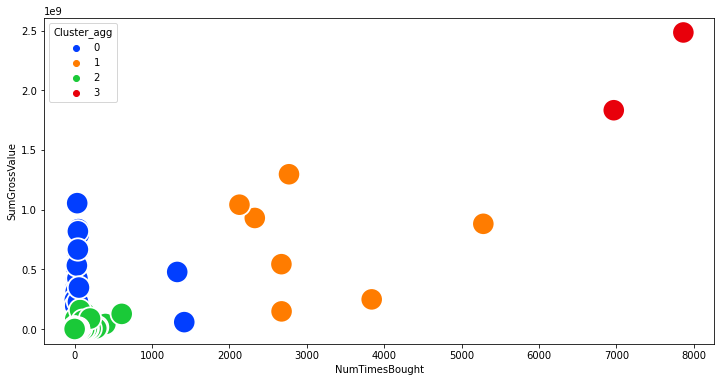

In [95]:
# Alggo cluster
plt.figure(figsize = (12, 6))
sns.scatterplot(data=df_sum, x="NumTimesBought", y="SumGrossValue", hue="Cluster_agg",palette="bright",s=500);

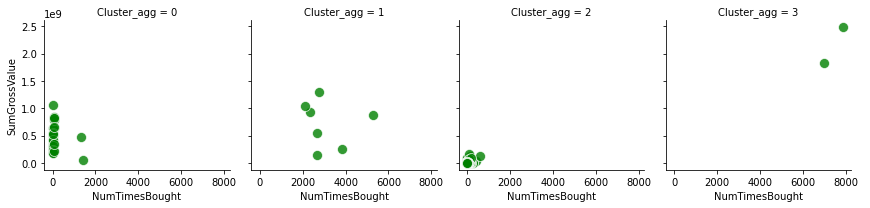

In [96]:
g = sns.FacetGrid(df_sum, col='Cluster_agg')
g.map(sns.scatterplot, "NumTimesBought", "SumGrossValue", s=100, alpha=.8,color='green',x_jitter=.1)
g.add_legend();

In [97]:
# On SImilar lines are the Kmeans one

In [98]:
df_sum.head()

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster_km,Cluster_agg
0,"""1/4 Ratchet 7-13mm Nuts",1,10250.00,1271.00,0,2
1,"""IND. Air Heating Ele. 2000 w ,240 V""",1,9880.00,2470.00,0,2
2,'biquiti - AirGrid M5 Hi-Power 27dbi,1,14400.00,7200.00,0,2
3,0028330 Frt.Bonnet Hings Kabja LH Bolero,1,719.00,481.73,0,2
4,0028334 Frt.Bonnet Hings Kabja RH Bolero,1,3440.00,2304.80,0,2


# Cluster ony Top 24 Material consitituting 80% of Gross Value

In [99]:
top_24_mat = ['IB Ross Broiler Finisher Feed', 'IB Ross Broiler Starter Feed',
       'Soya Bean - (MP)', 'B4 IB Ross Feed', 'Soya Bean - (A)', 'Maize',
       'IB Ross Broiler Pre-Starter Feed', 'PL-3', 'B1 IB Ross Feed',
       'PL-4', 'Feed P1', 'PL-5', 'B3 IB Ross Feed', 'B2 IB Ross Feed',
       'GP-5 Feed', 'Soya Bean', 'Grand Parents Layer', 'Feed PS',
       'Khandha', 'Grand Parents Grower', 'GP-4 Feed', 'C2',
       'Soya Crude Oil - Purchase', 'Grand Parents Starter']

In [100]:
df_cluster2 = df_cluster[df_cluster['Short Text'].isin(top_24_mat)]
df_cluster2.shape

(31929, 43)

In [101]:
df_sum_24 = df_cluster2.groupby('Short Text',as_index=False).agg(
    # Get count/frequency, can be any column
    NumTimesBought=('Purch.Doc.','count'),
    # Get total Gross Val 
    SumGrossValue=('Gross value','sum'),
    # Per unit price
    AvgPerUnitCost = ('Net Price','mean')
    
    )

df_sum_24.shape

(24, 4)

In [102]:
df_t = df_sum_24.drop(['Short Text','AvgPerUnitCost'], axis='columns')
# Scale 
scaler = preprocessing.StandardScaler()
df_scaled = scaler.fit_transform(df_t) # its an array 
df_scaled = pd.DataFrame(df_scaled, columns = df_t.columns) # convert back to data frame
df_scaled

,NumTimesBought,SumGrossValue
0,-0.56,0.04
1,-0.57,-0.34
2,-0.57,-0.33
3,-0.57,0.52
4,-0.58,-0.88
5,-0.57,-0.02
6,-0.58,-0.64
7,-0.58,-0.78
8,-0.58,-0.52
9,-0.57,-0.77


In [103]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster)
    kmeans.fit(df_scaled)
    SSE.append(kmeans.inertia_)

In [104]:
df_t = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})

Text(0, 0.5, 'Inertia')

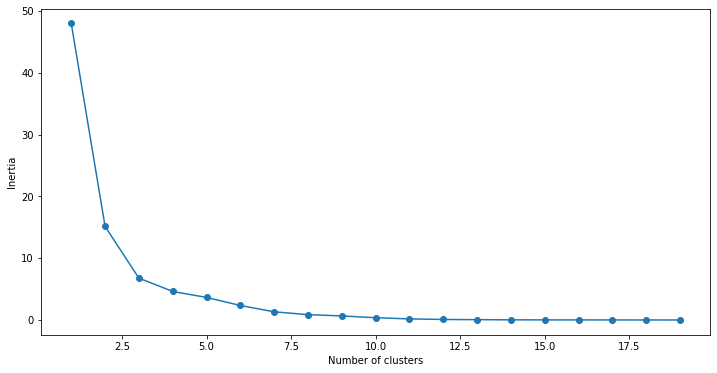

In [105]:
plt.figure(figsize=(12,6))
plt.plot(df_t['Cluster'], df_t['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [106]:
# Get 4 clusters 

In [107]:
df_scaled.head()

,NumTimesBought,SumGrossValue
0,-0.56,0.04
1,-0.57,-0.34
2,-0.57,-0.33
3,-0.57,0.52
4,-0.58,-0.88


In [108]:
km24 = KMeans(n_clusters = 4)
km24.fit(df_scaled)

KMeans(n_clusters=4)

In [109]:
km24.inertia_

4.620072583628052

In [110]:
# Add the clusters Labels to the data frame
df_sum_24['Cluster24_km'] = km24.labels_

In [111]:
df_sum_24['Cluster24_km'].value_counts()

2    9
1    8
3    5
0    2
Name: Cluster24_km, dtype: int64

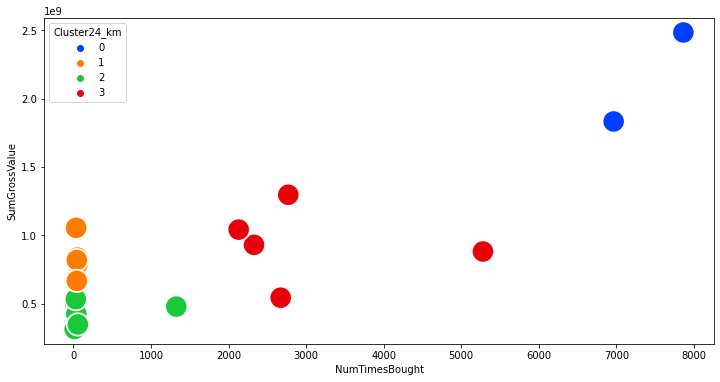

In [112]:
plt.figure(figsize = (12, 6))
sns.scatterplot(data=df_sum_24, x="NumTimesBought", y="SumGrossValue", hue="Cluster24_km",palette="bright",s=500);

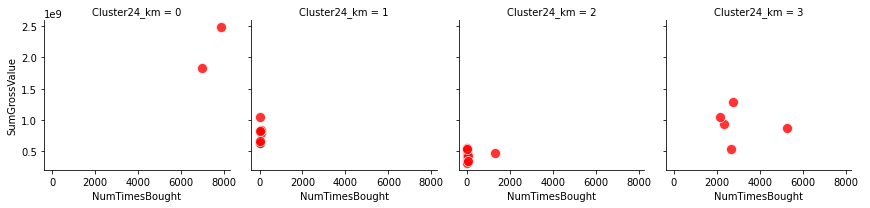

In [113]:
g = sns.FacetGrid(df_sum_24, col='Cluster24_km')
g.map(sns.scatterplot, "NumTimesBought", "SumGrossValue", s=100, alpha=.8,color='red',x_jitter=.1)
g.add_legend();

In [114]:
df_sum_24[df_sum_24['Cluster24_km'] == 0]

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster24_km
12,IB Ross Broiler Finisher Feed,7864,2484004973.38,29.04,0
14,IB Ross Broiler Starter Feed,6965,1832625208.50,30.29,0


In [115]:
df_sum_24[df_sum_24['Cluster24_km'] == 1]

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster24_km
0,B1 IB Ross Feed,57,820581512.40,29.14,1
1,B2 IB Ross Feed,44,631991204.70,27.61,1
2,B3 IB Ross Feed,39,636587726.50,26.24,1
3,B4 IB Ross Feed,34,1054080000.00,27.03,1
5,Feed P1,54,788459684.20,23.19,1
17,PL-3,50,836547216.05,24.87,1
18,PL-4,43,817984426.00,25.14,1
19,PL-5,43,665772945.15,24.73,1


In [116]:
df_sum_24[df_sum_24['Cluster24_km'] == 2]

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster24_km
4,C2,18,369002000.00,24.19,2
6,Feed PS,23,486108038.55,27.41,2
7,GP-4 Feed,20,419359019.25,26.04,2
8,GP-5 Feed,30,548267645.75,25.90,2
9,Grand Parents Grower,37,423651274.20,23.99,2
10,Grand Parents Layer,30,531899454.55,25.63,2
11,Grand Parents Starter,15,313953033.95,28.68,2
15,Khandha,1326,477715289.41,17.12,2
23,Soya Crude Oil - Purchase,57,347114889.25,70428.07,2


In [117]:
df_sum_24[df_sum_24['Cluster24_km'] == 3]

,Short Text,NumTimesBought,SumGrossValue,AvgPerUnitCost,Cluster24_km
13,IB Ross Broiler Pre-Starter Feed,5280,881006742.00,31.71,3
16,Maize,2328,929928411.41,17.80,3
20,Soya Bean,2672,542905344.06,35946.06,3
21,Soya Bean - (A),2130,1041177465.28,37573.95,3
22,Soya Bean - (MP),2770,1296246620.39,36982.17,3


In [118]:
df_km24_sum = df_sum_24.groupby('Cluster24_km',as_index=False).agg(
    NumMatInCluster=('NumTimesBought','count'),
    Avg_NumTimesBought=('NumTimesBought','mean'),
    Sum_NumTimesBought=('NumTimesBought','sum'),
    Avg_SumGrossValue=('SumGrossValue','mean'),
    Sum_SumGrossValue=('SumGrossValue','sum'),
    Avg_AvgPerUnitCost = ('AvgPerUnitCost','mean'),
)

df_km24_sum

,Cluster24_km,NumMatInCluster,Avg_NumTimesBought,Sum_NumTimesBought,Avg_SumGrossValue,Sum_SumGrossValue,Avg_AvgPerUnitCost
0,0,2,7414.50,14829,2158315090.94,4316630181.88,29.67
1,1,8,45.50,364,781500589.38,6252004715.00,25.99
2,2,9,172.89,1556,435230071.66,3917070644.91,7847.45
3,3,5,3036.00,15180,938252916.63,4691264583.14,22110.34


# Add the cluster value in  the raw/cleaned file and write the files

In [119]:
df.shape

(61870, 43)

In [120]:
df_info2 = df.merge(df_sum_24, on='Short Text', how='left')
df_info2.shape

(61870, 47)

In [121]:
# Write the files 
df_info2.to_csv("preprocessing/SA_clean_withClusterResults_top24.csv", index=False)